# Download data and process interferogram stack
George Brencher

## Create and configure environment

In [1]:
#Skip if environment is already created. 
!mamba create -n isce2 --file conda-linux-64.lock
!conda activate isce2
!python -m ipykernel install --user --name=isce2


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.9.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


_libgcc_mutex-0.1    | ################################################# | 100% 
ca-certificates-2021 | #########

Make sure kernel is set to 'Python [conda env:isce2]'

In [1]:
# Note--if processing on headless server, need to run the following for the stack processor to work: 
!pip install opencv-python-headless

  Using cached opencv_python_headless-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (47.8 MB)


In [2]:
# Import required packages
import logging
log = logging.getLogger()
log.setLevel(logging.WARN)
import os
import getpass
import asf_search as asf
import isce
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
from rasterio import logging
from osgeo import gdal

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-03-12 19:18:08,675 - matplotlib - DEBUG - matplotlib data path: /srv/conda/envs/isce2/lib/python3.9/site-packages/matplotlib/mpl-data
2022-03-12 19:18:08,689 - matplotlib - DEBUG - CONFIGDIR=/home/jovyan/.config/matplotlib
2022-03-12 19:18:08,692 - matplotlib - DEBUG - interactive is False
2022-03-12 19:18:08,693 - matplotlib - DEBUG - platform is linux
2022-03-12 19:18:08,694 - matplotlib - DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipi

'topStack' is a Sentinel 1 interferogram stack processing workflow which has been contributed to isce. To get access to topsStack, which does not come with the conda install of ISCE, we need to clone isce2 from github. 

In [3]:
# skip if already cloned
#!git clone https://github.com/isce-framework/isce2.git

In [3]:
# Change to work directory 
os.chdir('/home/jovyan/Friendly-InSAR-time-series')

In [4]:
# Set environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)

# Set path to topsStack workflow in ISCE source directory
CWD = os.getcwd()
os.environ['PATH']+=f':{CWD}/isce2/contrib/stack/topsStack'
print(os.environ['PATH'])

/srv/conda/envs/isce2/bin:/srv/conda/condabin:/srv/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/bin:/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/applications:/home/jovyan/Friendly-InSAR-time-series/isce2/contrib/stack/topsStack


In [5]:
# Make sure stack processing scripts are in path
!which stackSentinel.py

/home/jovyan/Friendly-InSAR-time-series/isce2/contrib/stack/topsStack/stackSentinel.py


In [6]:
# Do downloads and processing in a temporary folder to avoid clogging the disk
os.chdir('/tmp')

In [9]:
# make required directories
dirs = ['/tmp/orbital', '/tmp/SLC', '/tmp/DEM', '/tmp/AUX']
for i in dirs:
    if not os.path.exists(i):
        os.makedirs(i)

listdir('/tmp')

['orbital', 'DEM', 'AUX', 'tmpg8cb9akq_kernels', 'SLC']

## Download scenes

In [10]:
#check disk space prior to downloading SLCs
!df -h

Filesystem                                                Size  Used Avail Use% Mounted on
overlay                                                   194G   41G  153G  22% /
tmpfs                                                      64M     0   64M   0% /dev
tmpfs                                                      32G     0   32G   0% /sys/fs/cgroup
//pccwesteuropestorage.file.core.windows.net/driven-data  100G   26G   75G  26% /driven-data
/dev/sdd                                                   15G  397M   15G   3% /home/jovyan
/dev/sda1                                                 194G   41G  153G  22% /etc/hosts
tmpfs                                                      32G     0   32G   0% /dev/shm
tmpfs                                                      32G     0   32G   0% /proc/acpi
tmpfs                                                      32G     0   32G   0% /proc/scsi
tmpfs                                                      32G     0   32G   0% /sys/firmware


In [11]:
# Change to SLC directory 
os.chdir('/tmp/SLC')

In [12]:
# Update with NASA Earthdata login to download SLC data
EARTHDATA_LOGIN = 'qbrencherUW'
EARTHDATA_PASSWORD = getpass.getpass()

# prevent DEBUG messages
logging.getLogger('urllib3').setLevel(logging.WARNING)

try:
    user_pass_session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

 ········


Success!


In [13]:
# Create a persistent .netrc file for downloading NASA datasets (ISCE retrieves SRTM by default)
# https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget
!echo "machine urs.earthdata.nasa.gov login {EARTHDATA_LOGIN} password {EARTHDATA_PASSWORD}" > ~/.netrc
!chmod 0600 ~/.netrc

In [29]:
# Set bounding box (larger than processing extent by at least a degree) 
# Use southwest and northeast corner points of a box in [lat, lon] format
# Must use integers

# southwestern corner
lower_left = [-2, -92]

# northeastern corner
upper_right = [0, -90]

bbox = f'POLYGON(({lower_left[1]} {lower_left[0]}, {lower_left[1]} {upper_right[0]}, {upper_right[1]} {upper_right[0]}, {upper_right[1]} {lower_left[0]}, {lower_left[1]} {lower_left[0]}))'

In [15]:
# Set platform, season, start and end dates, flight direction, and processing level.
# May want to include frame if aoi is in scene overlap area
opts = {'platform': asf.PLATFORM.SENTINEL1,
        'season': '152,274',
        'start': '2021-08-01T00:00:00Z', 
        'end': '2021-09-01T00:00:00Z', 
        'flightDirection': 'D',
        'processingLevel': 'SLC',
        'frame': 593
       }

In [16]:
# search for scenes
results = asf.search(intersectsWith=bbox, **opts)
print(f'{len(results)} scenes found')

3 scenes found


In [17]:
# Download scenes 
#Each is ~4 GB
results.download(path = '/tmp/SLC', session=user_pass_session)

In [18]:
# Create a list of zipped SLCs. Assume there are no other files with .zip extension in SLC directory
tmp = listdir('/tmp/SLC')

scenes = []
for file in tmp:
    if file[-4:]=='.zip':
        scenes.append(file[:-4])
        
print(scenes)

['S1A_IW_SLC__1SDV_20210814T115028_20210814T115056_039225_04A186_B53A', 'S1A_IW_SLC__1SDV_20210826T115029_20210826T115057_039400_04A77E_828D', 'S1A_IW_SLC__1SDV_20210802T115028_20210802T115056_039050_049B92_CA89']


## Download precise orbitals 

In [19]:
os.chdir('/tmp/orbital')

In [20]:
!which fetchOrbit.py

/home/jovyan/Friendly-InSAR-time-series/isce2/contrib/stack/topsStack/fetchOrbit.py


In [21]:
# grab orbital files with fetchOrbit.py
for file in scenes:
    os.system(f'fetchOrbit.py -i {file}')

Reference time:  2021-08-14 11:50:56
Satellite name:  S1A
Reference time:  2021-08-26 11:50:57
Satellite name:  S1A
Reference time:  2021-08-02 11:50:56
Satellite name:  S1A


### Also download calibration auxliary file
A calibration auxliary (AUX_CAL) file is used for antenna pattern correction to compensate the range phase offset of SAFE products with IPF verison 002.36 (mainly for images acquired before March 2015). 

In [22]:
os.chdir('/tmp/AUX')
!wget https://qc.sentinel1.groupcls.com/product/S1A/AUX_CAL/2014/09/08/S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ

--2022-03-12 19:47:21--  https://qc.sentinel1.groupcls.com/product/S1A/AUX_CAL/2014/09/08/S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ
Resolving qc.sentinel1.groupcls.com (qc.sentinel1.groupcls.com)... 20.74.8.22
Connecting to qc.sentinel1.groupcls.com (qc.sentinel1.groupcls.com)|20.74.8.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494159 (483K)
Saving to: ‘S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ’

S1A_AUX_CAL_V201409 100%[===================>] 482.58K  --.-KB/s    in 0.06s   

2022-03-12 19:47:21 (8.54 MB/s) - ‘S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ’ saved [494159/494159]



## Specify or download digital elevation file
If using your own DEM, place it in the 'DEM' directory. Must be in WGS 84. Name your DEM 'demLat.......wgs84
If you don't provide a DEM, dem.py can be used to automatically download SRTM. 

In [23]:
os.chdir('/tmp/DEM')

In [24]:
# make sure dem.py is in path
!which dem.py

/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/applications/dem.py


In [31]:
# Examine bounding box
print(f'lower left (southwest): {lower_left}, upper right (northwest): {upper_right}')

lower left (southwest): [-2, -92], upper right (northwest): [0, -90]


In [30]:
# Feed dem.py ingeter coordinates surrounding the aoi, using the following structure: south lat, north lat, west lon, east lon 
os.system(f'dem.py -a stitch -b {lower_left[0]} {upper_right[0]} {lower_left[1]} {upper_right[1]} -r -s 1 -c')
!rm demLat*.dem demLat*.dem.xml demLat*.dem.vrt

API open (R): ./demLat_S02_N00_Lon_W092_W090.dem
API close:  ./demLat_S02_N00_Lon_W092_W090.dem
GDAL open (R): ./demLat_S02_N00_Lon_W092_W090.dem.vrt
API open (WR): demLat_S02_N00_Lon_W092_W090.dem.wgs84

    << Geoid Correction I2 SRTM>>

Jet Propulsion Laboratory - Radar Science and Engineering


Sampling Geoid at grid points -  Longitude Samples:    23 Latitude Lines:    23
Corner Geoid Heights (m) =   -7.97  -9.85  -8.01  -4.09

Correcting data to geoid height...

At line:      512
At line:     1024
At line:     1536
At line:     2048
At line:     2560
At line:     3072
At line:     3584
At line:     4096
At line:     4608
At line:     5120
At line:     5632
At line:     6144
At line:     6656
At line:     7168
GDAL close: ./demLat_S02_N00_Lon_W092_W090.dem.vrt
API close:  demLat_S02_N00_Lon_W092_W090.dem.wgs84
API open (R): demLat_S02_N00_Lon_W092_W090.dem.wgs84
API close:  demLat_S02_N00_Lon_W092_W090.dem.wgs84
This is the Open Source version of ISCE.
Some of the workflows depend

In [35]:
listdir('/tmp/DEM')

['demLat_S02_N00_Lon_W092_W090.dem.wgs84.vrt',
 'N01W092.SRTMGL1.hgt.zip',
 'N00W092.SRTMGL1.hgt.zip',
 'demLat_S02_N00_Lon_W092_W090.dem.wgs84',
 'N00W091.SRTMGL1.hgt.zip',
 'demLat_S02_N00_Lon_W092_W090.dem.wgs84.xml',
 'insar.log',
 'isce.log']

## Stack processing 

In [32]:
os.chdir('/tmp')

In [33]:
# Look at options for stack processing

!stackSentinel.py -h

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
usage: stackSentinel.py [-h] [-H] -s SLC_DIRNAME -o ORBIT_DIRNAME -a
                        AUX_DIRNAME [-w WORK_DIR] -d DEM [-m REFERENCE_DATE]
                        [-c NUM_CONNECTIONS] [-n SWATH_NUM] [-b BBOX]
                        [-t TEXT_CMD] [-x EXCLUDE_DATES] [-i INCLUDE_DATES]
                        [--start_date STARTDATE] [--stop_date STOPDATE]
                        [-z AZIMUTHLOOKS] [-r RANGELOOKS] [-f FILTSTRENGTH]
                        [--snr_misreg_threshold SNRTHRESHOLD]
                        [-p POLARIZATION] [-C {geometry,NESD}]
              

Set some options for processing

In [67]:
# Set number of interferograms to be made per scene
connections = 2

# Set coherence threshold for interferogram pixels
cfilter = 0.2

# Set number of looks in range. Level 1 SLC resolution in range: 2.3 m
rlooks = 9

# Set number of looks in azimuth. Level 1 SLC resolution in azimuth: 14.1 m 
zlooks = 2

# get DEM name
files = listdir('/tmp/DEM/')

for i in files:
    if i[:6] == 'demLat' and i[-5:] == 'wgs84':
        dem = i

print(f'number of connections: {connections}')
print(f'coherence threshold: {cfilter}')
print(f'looks in range: {rlooks}')
print(f'looks in azimuth: {zlooks}')
print(f'DEM name: {dem}')

number of connections: 2
coherence threshold: 0.2
looks in range: 9
looks in azimuth: 2
DEM name: demLat_S02_N00_Lon_W092_W090.dem.wgs84


In [69]:
# generate run files
# Set processing aoi here: south limit, north limit, west limit, east limit
!stackSentinel.py -s /tmp/SLC/ -o /tmp/orbital/ -a /tmp/AUX/ -d /tmp/DEM/$dem -r $rlooks -z $zlooks -c $connections -b '-0.6 -0.2 -91.8 -91.25' -f $cfilter

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Number of SAFE files found: 3
Number of SAFE files to be used (cover BBOX): 3
*****************************************
Number of dates : 3
List of dates : 
['20210802', '20210814', '20210826']
date      south      north
20210802 -1.538738 0.622212
20210814 -1.538889 0.622168
20210826 -1.538725 0.621958
*****************************************
The overlap region among all dates (based on the preview kml files):
 South   North   East  West 
-1.538725 0.621958 -93.186356 -90.618034
*****************************************
All dates (3)
['20210802', '20210814', '20210826']


In [70]:
os.chdir('/tmp/run_files')

In [71]:
%%time
# First run took 42 min
!sh run_01_unpack_topo_reference

Completed Parsing the Configuration file
Functions to be executed:
['Function-1', 'Function-2']
Running: Sentinel1_TOPS
['--dirname', '/tmp/SLC/S1A_IW_SLC__1SDV_20210802T115028_20210802T115056_039050_049B92_CA89.zip', '--swaths', '1 2 3', '--orbitdir', '/tmp/orbital', '--outdir', '/tmp/reference', '--auxdir', '/tmp/AUX', '--bbox', '-0.6 -0.2 -91.8 -91.25', '--pol', 'vv']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Input XML files:  ['/vsizip//tmp/SLC/S1A_IW_SLC__1SDV_20210802T115028_20210802T115056_039050_049B92_CA89.zip/S1A_IW_SLC__1SDV_20210802T115028_20210802T115056_039050_049B92_CA89.SAFE/annotation/s1a-iw1-slc-

In [88]:
# Plot some burst geometry files
os.chdir('/tmp/geom_reference/IW1')

# Set which burst to look at 
burst = 2 
geom_files = [f'hgt_0{burst}.rdr.vrt', f'incLocal_0{burst}.rdr.vrt', f'lat_0{burst}.rdr.vrt', f'lon_0{burst}.rdr.vrt', f'los_0{burst}.rdr.vrt', f'shadowMask_0{burst}.rdr.vrt']

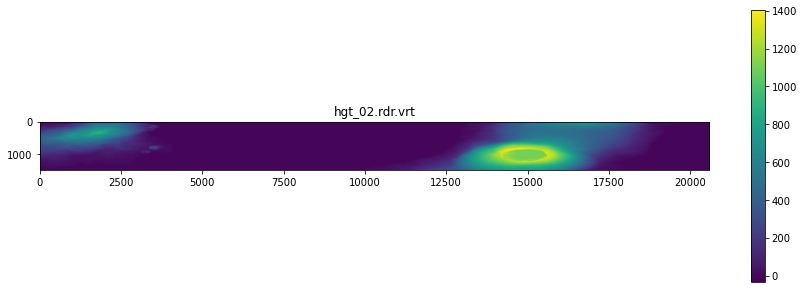

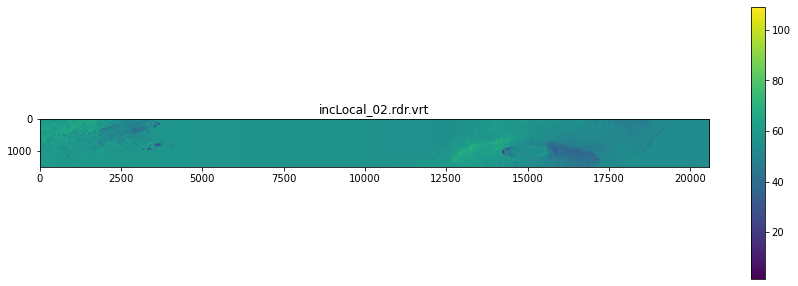

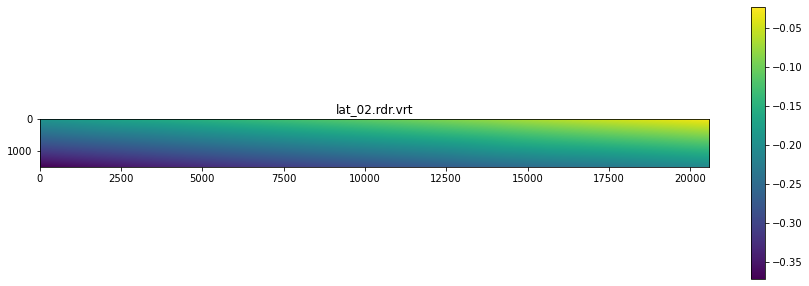

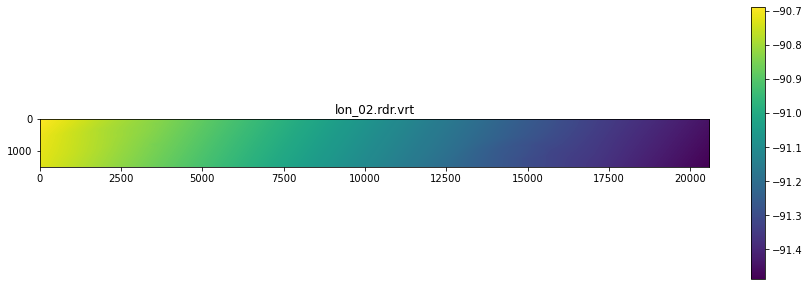

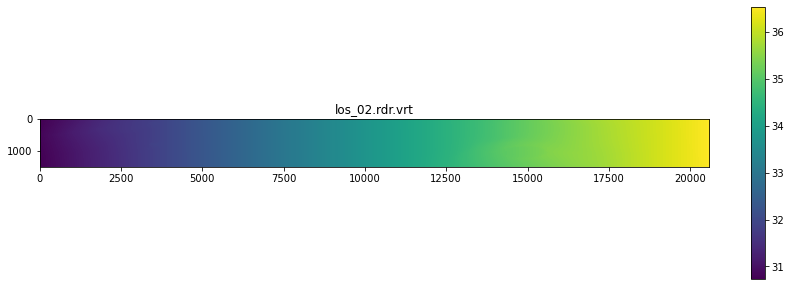

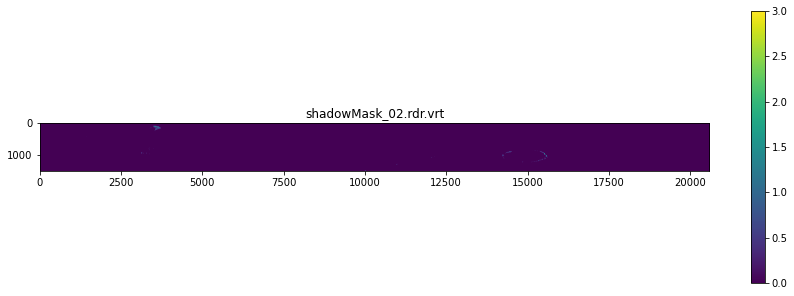

In [89]:
log = logging.getLogger()
log.setLevel(logging.WARN)

for file in geom_files:
    with rasterio.open(file) as src:
        geom = src.read(1)

    f, ax = plt.subplots(figsize=(15,5))
    im0 = ax.imshow(geom);
    f.colorbar(im0, ax=ax)
    ax.set_title(f'{file}')
    
os.chdir('/tmp/run_files')

In [87]:
%%time
!sh run_02_unpack_secondary_slc

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: Sentinel1_TOPS
['--dirname', '/tmp/SLC/S1A_IW_SLC__1SDV_20210814T115028_20210814T115056_039225_04A186_B53A.zip', '--swaths', '1 2 3', '--orbitdir', '/tmp/orbital', '--outdir', '/tmp/secondarys/20210814', '--auxdir', '/tmp/AUX', '--bbox', '-0.6 -0.2 -91.8 -91.25', '--pol', 'vv']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Input XML files:  ['/vsizip//tmp/SLC/S1A_IW_SLC__1SDV_20210814T115028_20210814T115056_039225_04A186_B53A.zip/S1A_IW_SLC__1SDV_20210814T115028_20210814T115056_039225_04A186_B53A.SAFE/annotation/s1a-iw1-slc-vv-2

In [90]:
%%time
!sh run_03_average_baseline

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: computeBaseline
['--reference', '/tmp/reference/', '--secondary', '/tmp/secondarys/20210814', '--baseline_file', '/tmp/baselines/20210802_20210814/20210802_20210814.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 5
minReference,maxReference 1 5
minBurst, maxBurst:  1 5
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Bprep:  [34.17192924412431, 34.24324371100418, 34.314055986060765, 

In [91]:
%%time
!sh run_04_extract_burst_overlaps

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Overlap 0 start time - IW-1 2021-08-02 11:50:33.695828 subset
Overlap 0 stop time - IW-1 2021-08-02 11:50:33.997995 subset
Overlap 0 number of lines - IW-1 148 subset
Overlap 0 number of valid lines - IW-1 113 subset
Top:  ['/tmp/reference/overlap/IW1/burst_top_01_02.slc']
Bottom:  ['/tmp/reference/overlap/IW1/burst_bot_01_02.slc']
Overlap 1 start time - IW-1 2021-08-02 11:50:36.454385 subset
Overlap 1 stop time - IW-1 2021-08-02 11:50:36.752440 subset
Overlap 1 number of lines - IW-1 146 subset
Overlap 1 number of valid lines - IW-1 112 subset
Top:  ['/tmp/reference/overl

In [92]:
%%time
# First run took 2 min
!sh run_05_overlap_geo2rdr

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/tmp/secondarys/20210814', '--reference', '/tmp/reference', '--geom_referenceDir', '/tmp/geom_reference', '--coregSLCdir', '/tmp/coreg_secondarys/20210814', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
CPU mode
Estimated burst offset:  0
Overlap pair 0: Burst 0 of reference matched with Burst 0 of secondary
Additional time offset applied in geo2rdr: 0.0 secs
Additional range offset applied in geo2rdr: 0.0 m
Turning off bistatic delay correction term by default.
API open (WR): /tmp/coreg_sec

In [93]:
%%time
# First run took 8 min
!sh run_06_overlap_resample

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/tmp/secondarys/20210814', '--reference', '/tmp/reference', '--coregdir', '/tmp/coreg_secondarys/20210814', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Estimated burst offset:  0
Shifts:  {0: 0, 1: 1, 2: 1, 3: 2, 4: 0}
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Chi squared: 0.000087
Polynomial Order: 5 - by - 3 
13157.5	-627.776	-1.35003	0.535821	
-51285.8	2408.86	-45.4736	-2.52198	
49976.1	-2310.19	93.7038	3.07095	
3.48297e-10	-6.94291e-10	2.80118e-10	0	


In [94]:
%%time
# First run took 13 min
!sh run_07_pairs_misreg

Completed Parsing the Configuration file
Functions to be executed:
['Function-1', 'Function-2', 'Function-3', 'Function-4']
Running: generateIgram
['--reference', '/tmp/reference', '--secondary', '/tmp/coreg_secondarys/20210814', '--interferogram', '/tmp/coarse_interferograms/20210802_20210814', '--interferogram_prefix', 'int', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 4
minReference,maxReference 1 4
minBurst, maxBurst:  1 4
matching burst numbers:  1 1
multiply
read
No range offsets provided
rdict:  {'rangeOff1': '/tmp/reference/overlap/IW1/range_bot_01_02.off', 'rangeOff2

In [95]:
%%time
!sh run_08_timeseries_misreg


Rank of design matrix: 2
Design matrix is full rank.
RMSE : 9.586330088495762e-05 pixels

Estimated offsets with respect to the stack reference date

20210802 : 0.0
20210814 : -0.0009576758110099765
20210826 : -3.53730322692862e-05


Rank of design matrix: 2
Design matrix is full rank.
RMSE : 0.012133136014142315 pixels

Estimated offsets with respect to the stack reference date

20210802 : 0.0
20210814 : -0.012133136104541215
20210826 : 0.04853254441816486

CPU times: user 13.4 ms, sys: 22.4 ms, total: 35.8 ms
Wall time: 1.28 s


In [96]:
%%time
# First run took 13 min
!sh run_09_fullBurst_geo2rdr

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/tmp/secondarys/20210814', '--reference', '/tmp/reference', '--geom_referenceDir', '/tmp/geom_reference', '--coregSLCdir', '/tmp/coreg_secondarys/20210814', '--azimuth_misreg', '/tmp/misreg/azimuth/dates/20210814.txt', '--range_misreg', '/tmp/misreg/range/dates/20210814.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
CPU mode
Estimated burst offset:  0
Overlap pair 0: Burst 0 of reference matched with Burst 0 of secondary
Burst 0 of reference matched with Burst 0 of secondary
Additional time offset a

In [97]:
%%time
# First run took 9 min
!sh run_10_fullBurst_resample

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/tmp/secondarys/20210814', '--reference', '/tmp/reference', '--coregdir', '/tmp/coreg_secondarys/20210814', '--azimuth_misreg', '/tmp/misreg/azimuth/dates/20210814.txt', '--range_misreg', '/tmp/misreg/range/dates/20210814.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Estimated burst offset:  0
Shifts:  {0: 0, 1: 1, 2: 1, 3: 2, 4: 0}
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Chi squared: 0.000087
Polynomial Order: 5 - by - 3 
13157.5	-627.776	-1.35003	0.535821	
-51

In [98]:
%%time
!sh run_11_extract_stack_valid_region

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
creating  /tmp/stack
checking the number of bursts in coreg_secondarys against the one in reference
all secondary images have the same number of bursts as the reference
******************
swath:  1
/tmp/coreg_secondarys/20210814
minSecondary,maxSecondary 1 5
minReference,maxReference 1 5
minBurst, maxBurst:  1 5
/tmp/coreg_secondarys/20210826
minSecondary,maxSecondary 1 5
minReference,maxReference 1 5
minBurst, maxBurst:  1 5
writing  /tmp/stack/IW1.xml
******************
swath:  2
/tmp/coreg_secondarys/20210814
minSecondary,maxSecondary 1 5
minReference,maxReference 1 5
m

In [99]:
%%time
!sh run_12_merge_reference_secondary_slc

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/tmp/stack', '--inp_reference', '/tmp/reference', '--dirname', '/tmp/reference', '--name_pattern', 'burst*slc', '--outfile', '/tmp/merged/SLC/20210802/20210802.slc', '--method', 'top', '--valid_only', '--use_virtual_files', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 5
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 5
False
S

In [107]:
# Plot merged geometry files
####### CURRENTLY BROKEN, ISCE IS FAILING TO GENERATE MERGED GEOMETRY FILES ########
#os.chdir('/tmp/merged/geom_reference/')
 
#geom_files = ['hgt.rdr.vrt', 'incLocal.rdr.vrt', 'lat.rdr.vrt', 'lon.rdr.vrt', 'los.rdr.vrt', 'shadowMask.rdr.vrt']

In [ ]:
#log = logging.getLogger()
#log.setLevel(logging.WARN)

#for file in geom_files:
   # with rasterio.open(file) as src:
    #    geom = src.read(1)

  #  f, ax = plt.subplots(figsize=(15,5))
  #  im0 = ax.imshow(geom);
  #  f.colorbar(im0, ax=ax)
   # ax.set_title(f'{file}')
    
#os.chdir('/tmp/run_files')

In [100]:
%%time
# First run took 3 min
!sh run_13_generate_burst_igram

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: generateIgram
['--reference', '/tmp/reference', '--secondary', '/tmp/coreg_secondarys/20210814', '--interferogram', '/tmp/interferograms/20210802_20210814', '--interferogram_prefix', 'fine']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 5
minReference,maxReference 1 5
minBurst, maxBurst:  1 5
matching burst numbers:  1 1
multiply
read
No range offsets provided
matching burst numbers:  2 2
multiply
read
No range offsets provided
matching burst numbers:  3 3
multiply
read
No range offsets provided
match

In [101]:
%%time
!sh run_14_merge_burst_igram

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/tmp/stack', '--inp_reference', '/tmp/interferograms/20210802_20210814', '--dirname', '/tmp/interferograms/20210802_20210814', '--name_pattern', 'fine*int', '--outfile', '/tmp/merged/interferograms/20210802_20210814/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 5
Updating th

In [102]:
%%time
# First run took 7 min
!sh run_15_filter_coherence

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/tmp/merged/interferograms/20210802_20210814/fine.int', '--filt', '/tmp/merged/interferograms/20210802_20210814/filt_fine.int', '--coh', '/tmp/merged/interferograms/20210802_20210814/filt_fine.cor', '--strength', '0.2', '--slc1', '/tmp/merged/SLC/20210802/20210802.slc.full', '--slc2', '/tmp/merged/SLC/20210814/20210814.slc.full', '--complex_coh', '/tmp/merged/interferograms/20210802_20210814/fine.cor', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022

In [109]:
%%time
# First run took 36 min. 
!sh run_16_unwrap

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/tmp/merged/interferograms/20210802_20210814/filt_fine.int', '--unw', '/tmp/merged/interferograms/20210802_20210814/filt_fine.unw', '--coh', '/tmp/merged/interferograms/20210802_20210814/filt_fine.cor', '--reference', '/tmp/reference', '--defomax', '2', '--rlks', '9', '--alks', '2', '--method', 'snaphu']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
unwrapping method :  snaphu

snaphu v1.4.2
Reading wrapped phase from file /tmp/merged/interferograms/20210802_20210814/filt_fine.int
No weight file specified.  Ass

## Sanity check

In [110]:
os.chdir('/tmp/merged/interferograms/')
tmp = listdir('/tmp/merged/interferograms/')

int_list = []
for i in tmp:
    if len(i) == 17 and i[8]=='_':
        int_list.append(i)

print(int_list)

['20210802_20210814', '20210802_20210826', '20210814_20210826']


/tmp/ipykernel_744/4086413806.py:12: RuntimeWarning: divide by zero encountered in log
  im0 = ax[0].imshow(np.log(amp));


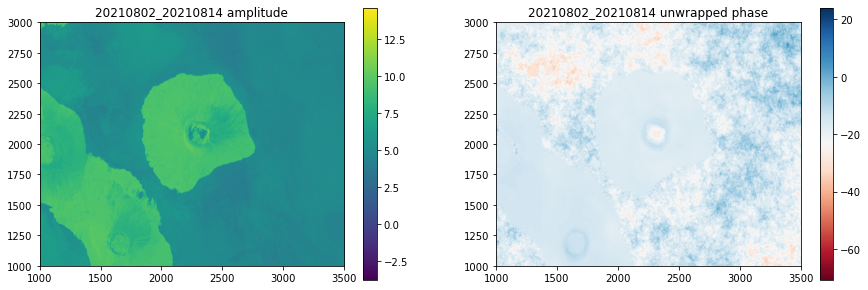

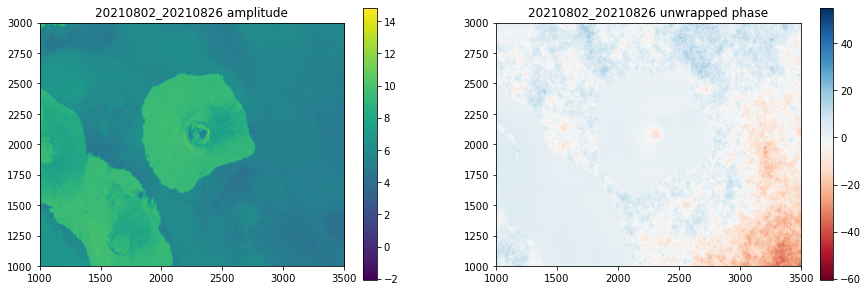

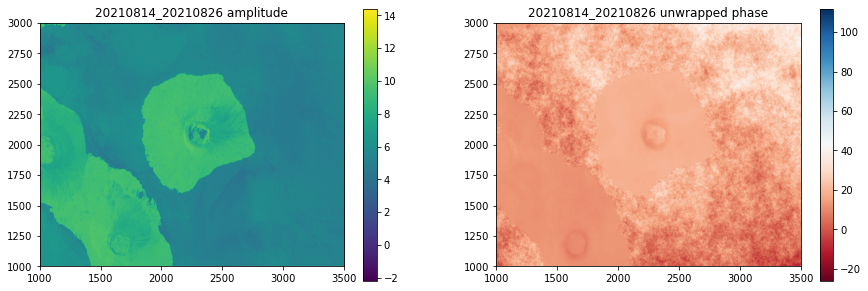

In [118]:
# Plot unwrapped interferograms
log = logging.getLogger()
log.setLevel(logging.WARN)

for i in int_list:
    os.chdir(f'/tmp/merged/interferograms/{i}')
    with rasterio.open('filt_fine.unw.vrt') as src:
        amp = src.read(1)
        phase = src.read(2)

    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    im0 = ax[0].imshow(np.log(amp));
    f.colorbar(im0, ax=ax[0])
    ax[0].set_title(f'{i} amplitude')
    ax[0].set_ylim(1000, 3000)
    ax[0].set_xlim(1000, 3500)
    
    im1 = ax[1].imshow(phase, cmap ='RdBu')
    f.colorbar(im1, ax=ax[1])
    ax[1].set_title(f'{i} unwrapped phase')
    ax[1].set_ylim(1000, 3000)
    ax[1].set_xlim(1000, 3500)

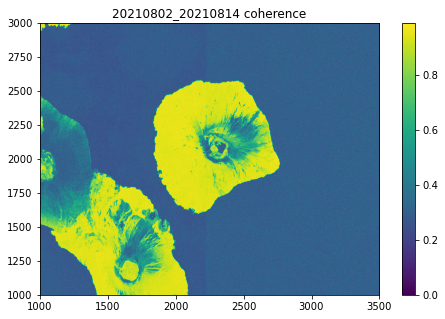

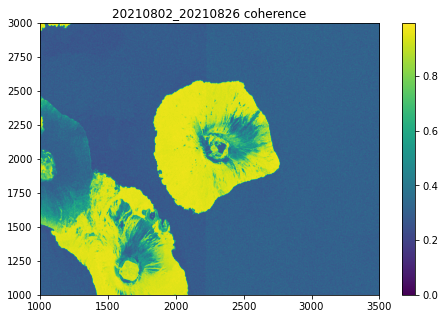

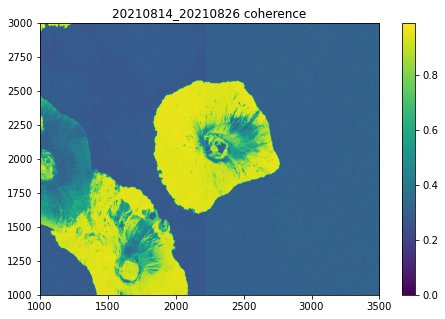

In [119]:
# Plot coherence
for i in int_list:
    os.chdir(f'/tmp/merged/interferograms/{i}')
    with rasterio.open('fine.cor.vrt') as src:
        coherence = src.read(2)

    fig, ax = plt.subplots(figsize=(8,5))
    im0 = ax.imshow(coherence);
    f.colorbar(im0, ax=ax)
    ax.set_title(f'{i} coherence')
    ax.set_ylim(1000, 3000)
    ax.set_xlim(1000, 3500)